# Pade approximation 

* Pade approximate is a ratio of two function.
* If we know power/ Taylor series then we can find Pade approx.
$$ P^N_M(x) = \frac{\sum^{N}_{i=0} A_ix^i}{\sum^{M}_{i=0} B_ix^i}  $$
 Compare $ P^N_M(x) $ with power/Taylor series $ \sum^{n}_{i=0} a_ix^i $ to get $A_i$ and $B_i$. 

### Python programing to compare Pade approx to actual EXP(x) for 5 Taylor coefficient

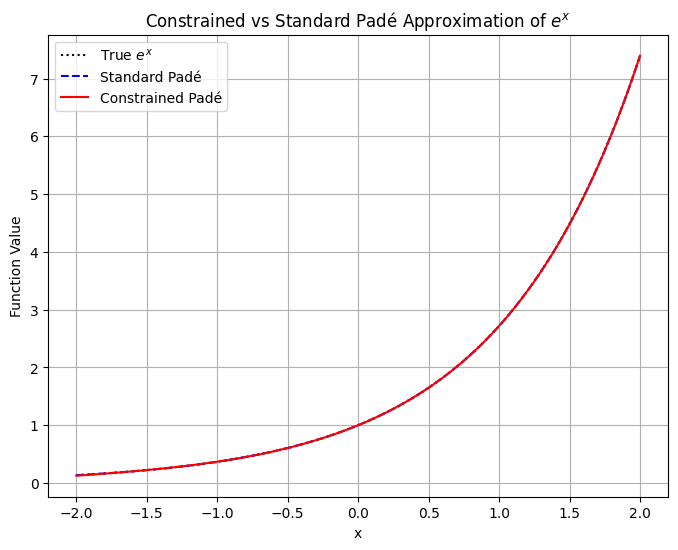

Optimized Constrained Padé Coefficients:
Numerator: [ 0.32584376  2.0785073   6.74684304 11.96579357  8.54075919  5.80578719]
Denominator: [ 0.10795724 -1.95525853  6.35306841  2.73559178  5.80461553]


In [11]:
import numpy as np
import math
import scipy.interpolate
import scipy.optimize
import matplotlib.pyplot as plt

# Function to approximate
def f(x):
    return np.exp(x)

# Compute Taylor series coefficients of e^x around x=0
n_terms = 5  # Order of approximation
taylor_coeffs = [1 / math.factorial(i) for i in range(2 * n_terms)]  # Maclaurin series

# Compute standard Padé approximation (m = n = n_terms)
pade_p, pade_q = scipy.interpolate.pade(taylor_coeffs, n_terms)

# Define constrained Padé function
def constrained_pade(coeffs, x):
    """ Construct constrained Padé approximation using optimized coefficients. """
    m = n_terms
    num = np.polyval(coeffs[:m+1], x)  # Numerator
    denom = np.polyval(coeffs[m+1:], x)  # Denominator
    return num / denom

# Constraint function: Ensure derivative at x = 0 is exactly 1
def constraint_func(coeffs):
    """ Enforce f'(0) = 1 by differentiating the constrained Padé approximant. """
    m = n_terms
    num_deriv_coeffs = np.polyder(coeffs[:m+1])  # Derivative of numerator
    denom_deriv_coeffs = np.polyder(coeffs[m+1:])  # Derivative of denominator

    num_deriv = np.polyval(num_deriv_coeffs, 0)
    denom_val = np.polyval(coeffs[m+1:], 0)
    denom_deriv = np.polyval(denom_deriv_coeffs, 0)

    f_prime_0 = (num_deriv * denom_val - np.polyval(coeffs[:m+1], 0) * denom_deriv) / (denom_val ** 2)
    
    return f_prime_0 - 1  # We want this to be zero

# Initial guess: Use standard Padé coefficients
initial_guess = np.concatenate((pade_p.coeffs, pade_q.coeffs))

# Apply constraint optimization with a weighted loss function
x_samples = np.linspace(-2, 2, 40)
weights = np.exp(-x_samples**2)  # Higher weight for central values

result = scipy.optimize.minimize(
    lambda coeffs: np.sum(weights * (f(x_samples) - constrained_pade(coeffs, x_samples)) ** 2),  # Weighted error minimization
    initial_guess,
    constraints={"type": "eq", "fun": constraint_func},  # Enforce f'(0) = 1
    method="SLSQP"
)

# Extract optimized coefficients
optimized_coeffs = result.x
numerator_coeffs = optimized_coeffs[:n_terms+1]
denominator_coeffs = optimized_coeffs[n_terms+1:]

# Evaluate fitted functions
x_vals = np.linspace(-2, 2, 100)
true_vals = f(x_vals)
pade_vals = pade_p(x_vals) / pade_q(x_vals)
constrained_vals = constrained_pade(optimized_coeffs, x_vals)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_vals, true_vals, label="True $e^x$", linestyle="dotted", color="black")
plt.plot(x_vals, pade_vals, label="Standard Padé", linestyle="dashed", color="blue")
plt.plot(x_vals, constrained_vals, label="Constrained Padé", linestyle="solid", color="red")
plt.xlabel("x")
plt.ylabel("Function Value")
plt.legend()
plt.grid(True)
plt.title("Constrained vs Standard Padé Approximation of $e^x$")
plt.show()

# Print results
print("Optimized Constrained Padé Coefficients:")
print(f"Numerator: {numerator_coeffs}")
print(f"Denominator: {denominator_coeffs}")
